In [ ]:
!pip install pandas
!pip install numpy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def generate_llmtime_string(df, column_name, target_min=1, target_max=100, nan_placeholder="NaN"):
    """
    Convert a time series column from a pandas DataFrame to LLMTIME format with adaptive scaling,
    ensuring integer values for the output.

    Args:
        df (pd.DataFrame): The input DataFrame with time series data.
        column_name (str): The name of the column to transform.
        target_min (int): Desired minimum value for the scaled data.
        target_max (int): Desired maximum value for the scaled data.
        nan_placeholder (str): Placeholder for NaN values.

    Returns:
        str: LLMTIME formatted string.
        float: Scaling factor used.
    """
    # Drop NaN values to calculate scaling factor, then calculate percentiles for scaling
    series = df[column_name].dropna()
    lower_bound = np.min(series) # np.percentile(series, 0.01)
    upper_bound = np.max(series) # np.percentile(series, 0.99)

    # Calculate scaling factor
    scale_factor = (target_max - target_min) / (upper_bound - lower_bound)

    # Scale, shift, and round data
    def scale_value(x):
        if pd.isna(x):
            return nan_placeholder
        scaled = (x - lower_bound) * scale_factor + target_min
        scaled_acc3 = int(scaled * 1000)
        return scaled_acc3

    scaled_series = df[column_name].apply(scale_value)

    # Convert values to formatted string
    formatted_values = []
    for value in scaled_series:
        if value == nan_placeholder:
            formatted_values.append(nan_placeholder)
        else:
            # Convert to string, add space between digits
            spaced_number = " ".join(str(value))
            formatted_values.append(spaced_number)

    # Join all values with comma separators
    llmtime_string = " , ".join(formatted_values)
    return llmtime_string

# Example usage:
# df = pd.DataFrame({'values': [1, 4, None, 7, 300, 450, -50]})
# llmtime_string, scale_factor = generate_llmtime_string(df, 'values', target_min=1, target_max=100)
# print("LLMTIME String:", llmtime_string)
# print("Scaling Factor:", scale_factor)


In [ ]:
df = pd.read_csv("AirtrafficA4.csv")

# Combine year and month into a datetime format, setting day as 1
df['YEAR_MONTH'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'] + '-01', format='mixed')

# Sort by date in ascending order to have the latest at the end
df = df.sort_values(by='YEAR_MONTH', ascending=True).set_index('YEAR_MONTH')

# convert the PASSENGERS CARRIED column to float
df['PASSENGERS CARRIED'] = df['PASSENGERS CARRIED'].str.replace(',', '').astype(float)

llmtime_string = generate_llmtime_string(df, 'PASSENGERS CARRIED')
print("LLMTIME String:", llmtime_string)

LLMTIME String: 1 6 7 2 7 , 1 5 8 9 7 , 1 6 9 2 1 , 1 8 0 0 8 , 2 0 1 7 1 , 1 7 6 3 3 , 1 7 1 9 0 , 1 8 2 6 1 , 1 6 3 6 3 , 1 7 9 9 7 , 1 7 4 7 0 , 1 8 8 1 3 , 1 6 9 5 8 , 1 7 4 2 4 , 1 9 1 2 7 , 2 0 1 0 7 , 2 2 9 4 4 , 2 1 5 6 2 , 1 9 1 1 3 , 2 2 3 2 7 , 2 2 9 3 2 , 2 2 7 2 0 , 2 3 6 8 6 , 2 8 1 1 2 , 2 7 5 1 8 , 2 6 9 4 9 , 2 7 6 3 9 , 3 0 0 6 4 , 3 3 6 4 2 , 3 0 7 5 0 , 2 9 2 6 4 , 2 8 8 6 6 , 2 9 4 3 2 , 3 1 4 1 3 , 3 1 5 1 1 , 3 3 3 2 0 , 3 3 1 0 1 , 3 3 4 5 4 , 3 6 7 9 8 , 3 7 3 3 6 , 4 0 6 9 4 , 3 6 7 9 6 , 4 1 2 7 8 , 4 0 7 4 7 , 4 0 1 8 5 , 4 5 1 1 8 , 4 6 1 0 9 , 4 7 0 5 0 , 4 6 5 6 4 , 4 1 7 1 0 , 4 4 1 0 6 , 4 6 1 8 6 , 5 1 3 0 7 , 4 6 7 7 0 , 4 5 2 0 0 , 4 4 9 3 7 , 4 4 7 6 6 , 5 0 5 8 8 , 5 0 5 7 3 , 5 4 2 7 9 , 5 5 8 5 5 , 5 2 5 4 0 , 5 6 0 9 5 , 5 6 1 4 0 , 5 9 5 3 3 , 5 7 2 9 3 , 6 1 3 9 0 , 5 8 3 4 6 , 6 0 3 7 0 , 6 2 2 9 0 , 6 1 4 3 4 , 6 7 3 0 6 , 6 5 3 5 9 , 6 0 4 9 8 , 6 6 8 3 7 , 6 7 3 3 8 , 7 3 5 3 2 , 7 1 0 3 2 , 6 9 9 7 7 , 6 8 0 7 9 , 6 8 3 0 7 , 7 1 8 2 7 , 

In [ ]:
def convert_to_original_scale(prediction_string, target_min, target_max, original_min, original_max):
    """
    Convert a prediction string from LLMTIME format back to the original scale.

    Args:
        prediction_string (str): The string of predictions in LLMTIME format, where each digit is spaced.
        target_min (int): Minimum value in the scaled range.
        target_max (int): Maximum value in the scaled range.
        original_min (int): Minimum value in the original range.
        original_max (int): Maximum value in the original range.

    Returns:
        list: List of predictions in the original scale.
    """
    # Parse the prediction string
    predictions = [
        int("".join(value.split()))/1000  # Join digits and convert to int
        for value in prediction_string.split(" , ")
        if value != "NaN"  # Skip any 'NaN' placeholders
    ]

    # Calculate the reverse scaling factor
    scale_factor = (original_max - original_min) / (target_max - target_min)

    # Reverse scale each prediction and round to ensure integer output
    original_predictions = [
        int(round((pred - target_min) * scale_factor + original_min)) for pred in predictions
    ]

    return original_predictions

# Example usage:
# prediction_string = "1 5 , 2 0 , 9 5 , 8 3"
# target_min, target_max = 1, 100
# original_min, original_max = -50, 450
# original_predictions = convert_to_original_scale(prediction_string, target_min, target_max, original_min, original_max)
# print("Original Scale Predictions:", original_predictions)


In [ ]:
# these are predictions obtained by the output of gpt-3
list_pred = [97143, 95877, 98203, 100455, 97001, 96422, 95589, 99067, 98481, 96953, 97844, 100285]

# convert list to string
list_pred = [' '.join(str(pred)) for pred in list_pred]

prediction_string = ' , '.join(list_pred)
print(prediction_string)

# original_min = np.percentile(df['PASSENGERS CARRIED'], 0.001)
original_min = df['PASSENGERS CARRIED'].min()
original_max = df['PASSENGERS CARRIED'].max()

original_predictions = convert_to_original_scale(prediction_string, 1, 100, original_min, original_max)

original_predictions = [pred for pred in original_predictions]

print("Original Scale Predictions:", original_predictions)

9 7 1 4 3 , 9 5 8 7 7 , 9 8 2 0 3 , 1 0 0 4 5 5 , 9 7 0 0 1 , 9 6 4 2 2 , 9 5 5 8 9 , 9 9 0 6 7 , 9 8 4 8 1 , 9 6 9 5 3 , 9 7 8 4 4 , 1 0 0 2 8 5
Original min: 142254.0
Original max: 8109626.0
Original Scale Predictions: [7879699, 7777813, 7965006, 8146244, 7868271, 7821674, 7754635, 8034540, 7987379, 7864408, 7936114, 8132562]


            PASSENGERS CARRIED
YEAR_MONTH                    
2023 SEP               7879699
2023 OCT               7777813
2023 NOV               7965006
2023 DEC               8146244
2024 JAN               7868271
2024 FEB               7821674
2024 MAR               7754635
2024 APR               8034540
2024 MAY               7987379
2024 JUN               7864408
2024 JUL               7936114
2024 AUG               8132562


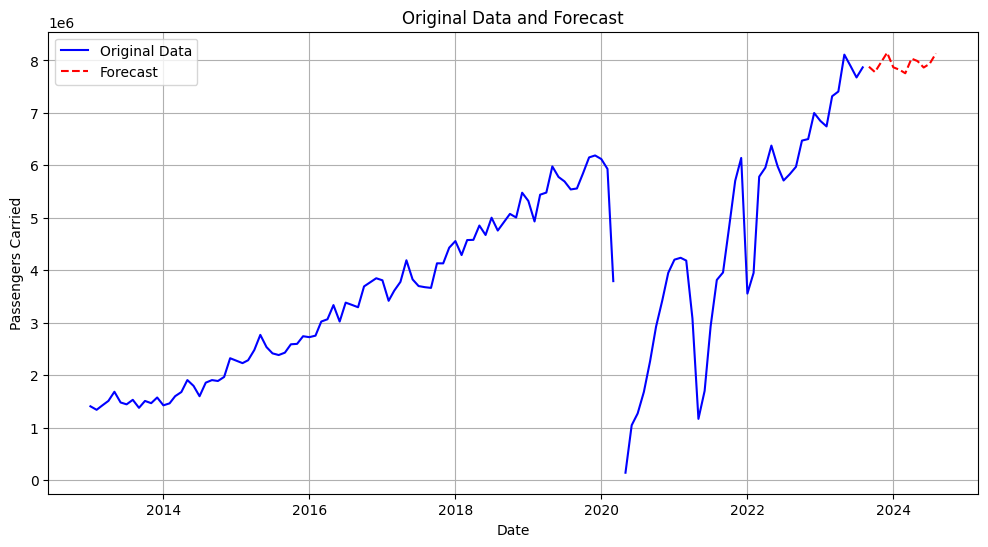

In [ ]:
# create a new data frame containing the predictions

forecast_index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')

prediction_df = pd.DataFrame({'YEAR_MONTH': forecast_index.strftime('%Y %b').str.upper(),
                              'PASSENGERS CARRIED': original_predictions})
prediction_df = prediction_df.set_index('YEAR_MONTH')
prediction_df.to_csv('forecast.csv', index=True)

# plot the original data, and then the predictions
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['PASSENGERS CARRIED'], label='Original Data', color='blue')
plt.plot(forecast_index, original_predictions, label='Forecast', color='red', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Passengers Carried')
plt.title('Original Data and Forecast')
plt.legend()
plt.grid(True)
plt.show()